# Dask graph experiments

This notebook explores in more details how the main Dask graph used to project
HSIC features on residuals performs on larger datasets.

In [ ]:
from pathlib import Path

import numpy as np
import h5py
import dask
import dask.bag as db
import dask.array as da
from dask import delayed
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

from hsic_optimization.hsic_tools import generate
from hsic_optimization.hsic_lasso import feature_accel, compute_kernel

## Dataset and parameter generation

First, let's generate a large dataset to make a fair comparison between the different approaches.

In [ ]:
n_samples = 1_000_000
n_features = 10_000
n_active = 10
dset_file = Path(f"../data/test_dataset_{n_features}_by_{n_samples}.h5")

In [ ]:
if not dset_file.exists():
    generate(dset_file, samples=n_samples, feats=n_features, active=n_active, seed=1234)

The target data for HSIC lasso can also be precomputed in advance.

In [ ]:
with h5py.File(dset_file, "r") as fd:
    Y = np.array(fd["Y"])

B = 20
M = 3
scale = np.sqrt(B / (Y.size * M))

L = compute_kernel(Y[None, :], "Delta", B, M, discarded=0) * scale

## Slurm-based Dask cluster

For the next experiments, I define a function to start a cluster based on Slurm
jobs.

In [ ]:
def start_cluster(n_workers):
    cluster = SLURMCluster(
        cores=4,
        processes=4,
        memory="8GiB",
        walltime="0-00:20",
        log_directory="../dask/logs",
        local_directory="../dask",
        interface="ib0",
    )
    client = Client(cluster)

    cluster.scale(n=n_workers)
    client.wait_for_workers(n_workers)

    return cluster, client

And as usual, let's make sure that no data is saved on drive by workers when
they run out of memory.

In [ ]:
_ = dask.config.set(
    {
        "distributed.worker.memory.target": False,  # avoid spilling to disk
        "distributed.worker.memory.spill": False,  # avoid spilling to disk
    }
)

## Algorithm using dask.bag

In this first experiment, I'll use `dask.bag` to run the projection step.

In [ ]:
cluster, client = start_cluster(20)

First, the HSIC features are created as a distributed collection, on a subset
for illustration purposes before running on all features.

In [ ]:
def feature(i):
    with h5py.File(dset_file, "r") as fp:
        return fp["X"][i]


def load_features(n_features, chunksize):
    indices = db.from_sequence(range(n_features), partition_size=chunksize)
    all_features = indices.map(feature)
    return all_features


all_features = load_features(40, 10)

Next, the projections of each feature on the target variables is computed using
the `map` function of the distributed collection. The target data is sent to all
workers using `client.scatter(..., broadcast=True)` before the projection step.

In [ ]:
def project_features(all_features, y, client):
    def project(x, y):
        return feature_accel(x, B, M, 0, scale) @ y

    y = client.scatter(y, broadcast=True)
    inner_products = all_features.map(project, y)
    return inner_products


inner_products = project_features(all_features, L, client)

The corresponding Dask graph is very straighforward, one task per chunk in the
distributed collection.

In [ ]:
inner_products.visualize()

The result of the `inner_products` being a list, it needs to be converted into a
numpy array to be useful in the rest of the code.

In [ ]:
%%time
np.array(inner_products.compute())

In [ ]:
client.close()
cluster.close()

Now that we know that it works, we can scale it using more features and see how
well the Dask graph behaves (e.g. compute vs. transfers). To make computations
a bit faster, let's also restart the cluster wit more workers.

In [ ]:
cluster, client = start_cluster(200)

In [ ]:
all_features = load_features(n_features, 10)
inner_products = project_features(all_features, L, client)

In [ ]:
%%time
_ = np.array(inner_products.compute())

*Note: compute vs. transfers (captured on a previous run)*

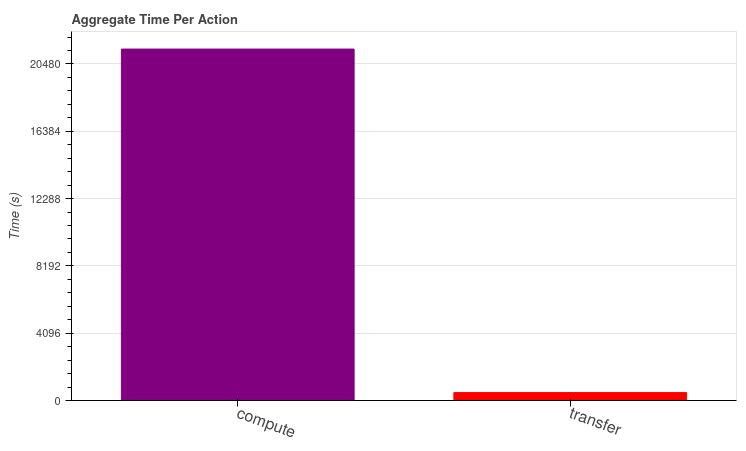

Changing the chunksize modifies how many tasks are in the graph:

- more tasks means possibly means more bookkeeping for the scheduler,
- but more tasks also means more opportunities to use pending workers to do
  computations.

So there is probably a good tradeoff to be found here...

In [ ]:
all_features = load_features(n_features, 5)
inner_products = project_features(all_features, L, client)

In [ ]:
%%time
_ = np.array(inner_products.compute())

In [ ]:
client.close()
cluster.close()

The `dask.bag` interface is simple and seems to perform well in the current case,
when data is loaded from disk.

If the `feature` function was loading from an array in memory, this array would
serialized to each worker and put a lot more pressure on their memory
consumption. This could be considered as an issue if we want to make the
`cd_hsic_lasso` function generic enough to handle both cases (data in memory or
loaded from disk).

## Algorithm based on dask.array - version 1

The `dask.array` interface makes it possible to create a numpy-like array, made
of disjoint chunks.

In [ ]:
cluster, client = start_cluster(20)

One way to use `dask.array` to create a distributed array from the data is to
create a list of delayed functions, to load each features, and then convert
these as dask arrays. These arrays are concatenated to obtain the final
distributed array.

In [ ]:
def load_features(n_features):
    @delayed
    def load_chunk(i):
        with h5py.File(dset_file, "r") as fp:
            return fp["X"][i]

    X = da.stack(
        [
            da.from_delayed(load_chunk(i), (n_samples,), dtype=np.uint8)
            for i in range(n_features)
        ],
        axis=0,
    )
    return X


X = load_features(40)

In [ ]:
X

To compute the projection of each feature on the target data, we can use the
`map_blocks` method of the distributed array, to compute the HSIC feature and
the dot product in one pass over the data.

In [ ]:
def project_block(chunk, y):
    return np.array([feature_accel(x, B, M, 0, scale) @ y for x in chunk])


def project_features(X, y, client):
    y = client.scatter(y, broadcast=True)
    inner_products = X.map_blocks(project_block, dtype=np.float32, drop_axis=1, y=y)
    return inner_products


inner_products = project_features(X, L, client)

The resulting Dask graph contains more operations than the `dask.bag` version,
as operations are not grouped using some chunking mechanisms.

In [ ]:
inner_products.visualize()

In [ ]:
%%time
inner_products.compute()

In [ ]:
client.close()
cluster.close()

To benchmark this graph, let's use all the features and a larger Dask cluster.

In [ ]:
cluster, client = start_cluster(200)

In [ ]:
X = load_features(n_features)
inner_products = project_features(X, L, client)

In [ ]:
%%time
_ = np.array(inner_products.compute())

*Note: compute vs. transfers (captured on a previous run)*

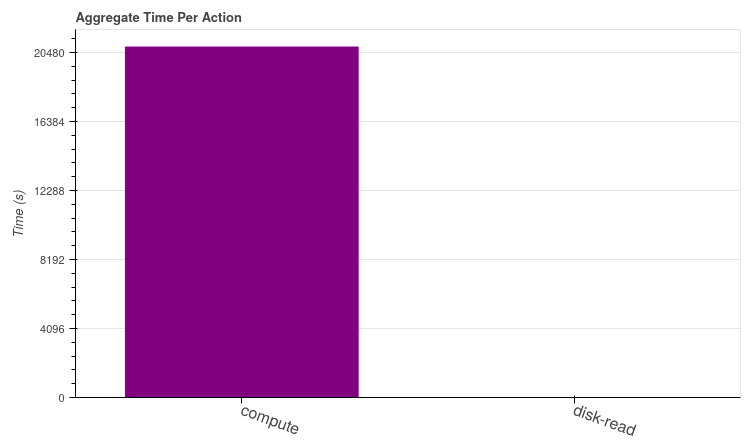

In [ ]:
client.close()
cluster.close()

## Algorithm based on dask.array - version 2

In this second version, let's try to load the data from disk, by chunks to keep
a compact Dask graph.

In [ ]:
cluster, client = start_cluster(20)

In [ ]:
fd = h5py.File(dset_file)
X = da.from_array(fd["X"][:40], chunks=(10, n_samples))

In [ ]:
X

In [ ]:
inner_products = project_features(X, L, client)

The corresponding graph is simpler, as there is only one task per block.

In [ ]:
inner_products.visualize()

In [ ]:
%%time
inner_products.compute()

In [ ]:
client.close()
cluster.close()

Once again, let's use all features and more workers to benchmark this code.

In [ ]:
cluster, client = start_cluster(200)

In [ ]:
X = da.from_array(fd["X"], chunks=(10, n_samples))
inner_products = project_features(X, L, client)

In [ ]:
%%time
_ = np.array(inner_products.compute())

*Note: compute vs. transfers (captured on a previous run)*

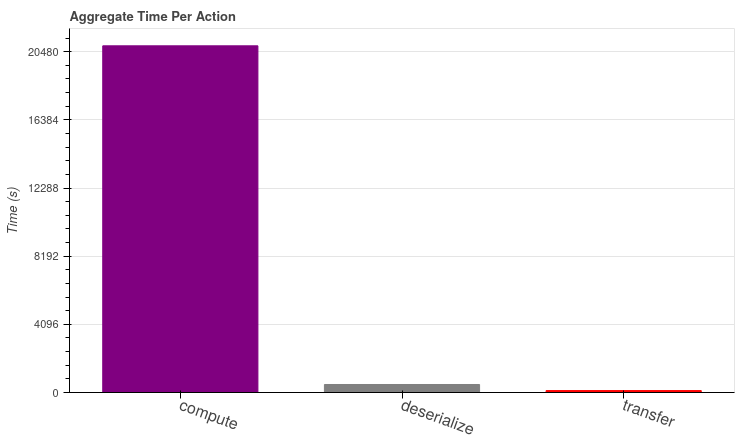

We can try to change the chunksize to see how this affects the performances.

In [ ]:
X = da.from_array(fd["X"], chunks=(5, n_samples))
inner_products = project_features(X, L)

In [ ]:
%%time
_ = np.array(inner_products.compute())

In [ ]:
client.close()
cluster.close()

In [ ]:
fd.close()

## Additional notes

For very large-scale and long running computations, it turns out that none of
these solutions are suitable, due to the way Dask deals with dying workers.
Indeed, the results of the Dask tasks are held on a worker until the full
computation is done. For a long running computation, the Slurm jobs hosting the
Dask workers might stop before the end of the computation, cancelling all
results computed by these workers.

To avoid this, the only method I have found so far is to use the [Futures API](https://docs.dask.org/en/stable/futures.html)
which permits the retrieval of results as soon as they are ready, avoiding
wasted computations. The code is very similar to the `dask.bag` code in spirit.